# Empirical Distribution Predictors

We may be losing a lot of information in the annotations by condensing them into a single number. Instead, we can train a model to predict the empirical distribution formed by the annotations over the answer choices. We do this by minimizing the cross-entropy between the predicted distributions and the empirical distributions. This is essentially softmax classification, but off-the-shelf implementations don't let you pass a distribution as a training label, so we have to roll our own in TensorFlow.

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf

from ngram import *
from baselines import *
from error_analysis import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
d = tidy_labels(pd.concat(load_cf_data()))
d = d.dropna(subset=['attack', 'aggression_score'])
d = d.iloc[np.random.permutation(np.arange(d.shape[0]))]

In [5]:
ngram_feature_pipeline = Pipeline([
    ('vect', CountVectorizer(ngram_range = (1,5), analyzer = 'char', max_features = 10000)),
    ('tfidf', TfidfTransformer(sublinear_tf=True,norm='l2')),
])

In [9]:
training_epochs = 50
batch_size = 500
display_step = 500

# Attack Model

In [7]:
labels = empirical_dist(d['attack'], w = 0.25)
data = get_labeled_comments(d, labels)
train, test = train_test_split(data, test_size = 0.2, random_state=0)

y_train =train.ix[:, train.columns != 'x'].values
y_test =test.ix[:, train.columns != 'x'].values

ngram_feature_extractor = ngram_feature_pipeline.fit(train['x'])
X_train = ngram_feature_extractor.transform(train['x'])
X_test = ngram_feature_extractor.transform(test['x'])

Fit a softmax regression to the empirical distribtion of annotions over answer choices.

Batch: 0001 cost= 7.028012753

	Train Micro ROC: 0.205232128312
	Test Micro ROC: 0.2065062642

	Train Micro F1: 0.300989339899
	Test Micro F1: 0.301445854234

	Train Macro F1: 0.300989339899
	Test Macro F1: 0.301445854234

	Train Pearson Correlation:  0.139341666992
	Test Pearson Correlation:  0.127416672306

	Train Spearman Correlation:  0.0982699857812
	Test Spearman Correlation:  0.0951410823832


Batch: 0501 cost= 3.492579921

	Train Micro ROC: 0.778246868924
	Test Micro ROC: 0.777909645588

	Train Micro F1: 0.443312201003
	Test Micro F1: 0.441190072453

	Train Macro F1: 0.443312201003
	Test Macro F1: 0.441190072453

	Train Pearson Correlation:  0.321937028063
	Test Pearson Correlation:  0.309909941979

	Train Spearman Correlation:  0.219752440467
	Test Spearman Correlation:  0.215255828027


Batch: 1001 cost= 2.033289483

	Train Micro ROC: 0.864158854824
	Test Micro ROC: 0.862286487789

	Train Micro F1: 0.530075006049
	Test Micro F1: 0.520325203252

	Train Macro F1: 0.530075006049

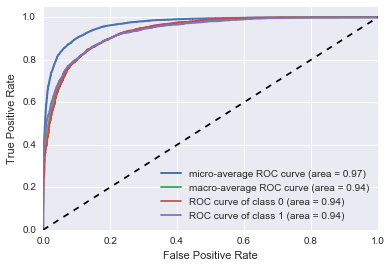

In [10]:
ED_CLF(X_train,
        y_train,
        X_test,
        y_test,
        training_epochs = training_epochs,
        batch_size = batch_size,
        display_step = display_step)

Fit a softmax regression to the most common annotation. 

Batch: 0001 cost= 6.241589546

	Train Micro ROC: 0.304704491453
	Test Micro ROC: 0.305181934182

	Train Micro F1: 0.275763156031
	Test Micro F1: 0.277872099604

	Train Macro F1: 0.275763156031
	Test Macro F1: 0.277872099604

	Train Pearson Correlation:  -0.00417322536395
	Test Pearson Correlation:  0.0104417074119

	Train Spearman Correlation:  -0.00522637365095
	Test Spearman Correlation:  0.00961726504793


Batch: 0501 cost= 3.132837608

	Train Micro ROC: 0.870475378634
	Test Micro ROC: 0.868332842173

	Train Micro F1: 0.426024739268
	Test Micro F1: 0.416425120773

	Train Macro F1: 0.426024739268
	Test Macro F1: 0.416425120773

	Train Pearson Correlation:  0.351232914415
	Test Pearson Correlation:  0.35734079807

	Train Spearman Correlation:  0.243563883999
	Test Spearman Correlation:  0.251084032271


Batch: 1001 cost= 1.724660721

	Train Micro ROC: 0.92264128929
	Test Micro ROC: 0.920464112554

	Train Micro F1: 0.532119568726
	Test Micro F1: 0.52029997414

	Train Macro F1: 0.532119

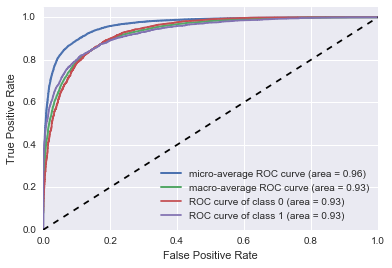

In [11]:
ED_CLF(X_train,
        y_train,
        X_test,
        y_test,
        training_epochs = training_epochs,
        batch_size = batch_size,
        display_step = display_step,
        one_hot = True)

Conclusion: Spearman is 5 points higher in EDP model, Pearson and ROC are about the same. Spearman seems more appropriate than pearson (see link):

https://stats.stackexchange.com/questions/11746/what-could-cause-big-differences-in-correlation-coefficient-between-pearsons-an

# Agression Model

Fit a softmax regression to the empirical distribtion of annotions over answer choices.

In [12]:
labels = empirical_dist(d['aggression_score'], w = 0.25)
data = get_labeled_comments(d, labels)
train, test = train_test_split(data, test_size = 0.2, random_state=0)

y_train =train.ix[:, train.columns != 'x'].values
y_test =test.ix[:, train.columns != 'x'].values

ngram_feature_extractor = ngram_feature_pipeline.fit(train['x'])
X_train = ngram_feature_extractor.transform(train['x'])
X_test = ngram_feature_extractor.transform(test['x'])

Batch: 0001 cost= 19.813297272

	Train Micro ROC: 0.631727590547
	Test Micro ROC: 0.634349602164

	Train Micro F1: 0.174617783914
	Test Micro F1: 0.179370057268

	Train Macro F1: 0.0646730604373
	Test Macro F1: 0.0635479192709

	Train Pearson Correlation:  0.00913163662898
	Test Pearson Correlation:  0.0104912945557

	Train Spearman Correlation:  0.0123613368578
	Test Spearman Correlation:  0.0134183521907


Batch: 0501 cost= 9.926151210

	Train Micro ROC: 0.915149431206
	Test Micro ROC: 0.915856370431

	Train Micro F1: 0.778749296927
	Test Micro F1: 0.783269702754

	Train Macro F1: 0.170893822215
	Test Macro F1: 0.17048602654

	Train Pearson Correlation:  0.154197023677
	Test Pearson Correlation:  0.147979369572

	Train Spearman Correlation:  0.128963076402
	Test Spearman Correlation:  0.124283404218


Batch: 1001 cost= 5.432680833

	Train Micro ROC: 0.945768709026
	Test Micro ROC: 0.945568449652

	Train Micro F1: 0.820234869015
	Test Micro F1: 0.8218571039

	Train Macro F1: 0.1945481

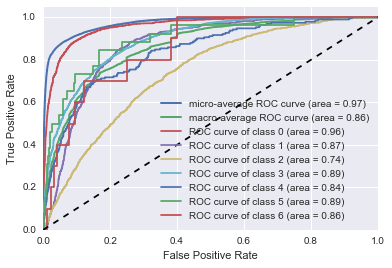

In [13]:
ED_CLF(X_train,
        y_train,
        X_test,
        y_test,
        training_epochs = training_epochs,
        batch_size = batch_size,
        display_step = display_step)

Batch: 0001 cost= 19.211345673

	Train Micro ROC: 0.726348183964
	Test Micro ROC: 0.728306010657

	Train Micro F1: 0.265344037088
	Test Micro F1: 0.26718025634

	Train Macro F1: 0.0817254650726
	Test Macro F1: 0.0829986649455

	Train Pearson Correlation:  -0.0864399485101
	Test Pearson Correlation:  -0.0871451054383

	Train Spearman Correlation:  -0.0574993626955
	Test Spearman Correlation:  -0.052784812023


Batch: 0501 cost= 9.306561569

	Train Micro ROC: 0.935305254853
	Test Micro ROC: 0.935856741582

	Train Micro F1: 0.798401254453
	Test Micro F1: 0.801881647123

	Train Macro F1: 0.158784223627
	Test Macro F1: 0.160156932215

	Train Pearson Correlation:  0.0685151395992
	Test Pearson Correlation:  0.0608361961157

	Train Spearman Correlation:  0.0553688633218
	Test Spearman Correlation:  0.0546028410853


Batch: 1001 cost= 4.795949735

	Train Micro ROC: 0.95477749127
	Test Micro ROC: 0.95442116644

	Train Micro F1: 0.829029673945
	Test Micro F1: 0.829492773384

	Train Macro F1: 0.1

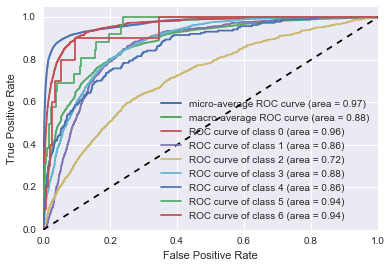

In [14]:
ED_CLF(X_train,
        y_train,
        X_test,
        y_test,
        training_epochs = training_epochs,
        batch_size = batch_size,
        display_step = display_step,
        one_hot = True)